In [276]:
import requests
from bs4 import BeautifulSoup
# pip install lxml
import pickle
import random
import igraph as ig
from collections import defaultdict
import json

## Graph des directeurs de thèses --> thésards

Avec les données du site theses.fr, et l'api:
http://documentation.abes.fr/aidethesesfr/accueil/index.html#RecupererDonneesPagePersonne

Les info sur les thèses sont récupérées avec des requètes sur une personne, puis sur les personnes connexes. 


In [277]:
def parse_foaf(tag):
    try:
        name = tag.text
        person_id = tag.findChild().attrs['rdf:about']
    except KeyError:
        # print(tag)
        name, person_id = (tag.text, None)
    return (name, person_id)


def query_someone(person_id):
    url = person_id.replace('/id', '.xml')

    r = requests.get(url)
    
    soup = BeautifulSoup(r.text, 'lxml-xml')
    
    # own thesis
    agent = soup.find('foaf:Agent')
    person_id = agent.attrs['rdf:about']
    name = agent.find('name').text
    person = (name, person_id)
    
    # other thesis
    linked_thesis = []
    for th in soup.find_all('Thesis'):
        info = dict()
        info['title'] = th.find('title').text
        info['author'] = parse_foaf( th.find('aut') )
        info['id'] = th.attrs['rdf:about']
        info['url'] = th.find('identifier').text if th.find('identifier') else ''
        try:
            info['year'] = int(th.find('date').text)
        except ValueError:
            info['year'] = 0
        info['directors'] = [parse_foaf(ths) for ths in th.find_all('ths')]
        info['doctoral_school'] = parse_foaf(th.find('contributor')) if th.find('contributor') else ()
        info['univ'] = parse_foaf(th.find('dgg'))

        linked_thesis.append(info)

    return person, linked_thesis

In [278]:
def is_valid_id(foaf_id):
    return foaf_id.endswith('/id') and not foaf_id.endswith('//id')

In [279]:
# Objet qui stocke les données explorées
# et les requetes suivante à faire
class Blob():
    def __init__(self, seed_id):
        self.already_asked = set()
        self.to_search = set([seed_id, ])
        self.thesis = dict()
        self.seed = seed_id
        self.chains = dict()
        self.nbr_gen = 0
        self.name = seed_id.split('/')[-2]
        
    def grow(self):
        person_id = self.to_search.pop()
       
        full_id, results = query_someone(person_id)
        print('\r', full_id[0], '(%i theses)'%len(results), end='')
        self.already_asked.add(person_id)
        self.nbr_gen += 1
        
        a_dirige = []
        related = []
        own_thesis = {'author':full_id,
                      'year':0,
                      'id':None,
                      'directors':[]} # default value
        for th in results:
            if full_id == th['author']:
                own_thesis = th
            elif full_id in (d for d in th['directors']):
                a_dirige.append(th)
            else:
                related.append(th)

        a_dirige.sort(key=lambda x:x['year'])

        #print(len(results), len(a_dirige), len(related))
        co_directors = {d for th in a_dirige+[own_thesis, ]
                          for d in th['directors'] if d!=full_id}
        students = {th['author'] for th in a_dirige}

        new_person = [p[1] for p in co_directors | students
                      if is_valid_id(p[1]) and p[1] not in self.already_asked]

        self.to_search.update(new_person)
        self.thesis.update({th['id']:th for th in a_dirige})
        if len(a_dirige)>0:
            chain = [(th['author'], th['year']) for th in a_dirige]
            self.chains[full_id] = [(full_id, own_thesis['year']), ] + chain
            
        
    def save(self, name='blob.p'):
        pickle.dump(self, open( name, "wb" ))
        print("saved")
        
    def print_info(self):
        print('nbr thesis:', len(blob.thesis))
        print('nbr to search:', len(blob.to_search))
        print(self.seed, '+', self.nbr_gen, 'generations')

In [384]:
# Get a random seed
seedlist_file = "data/seedlist.pick"
try:
    seedlist = pickle.load( open( seedlist_file, "rb" ) )
    print('seedlist loaded:', len(seedlist), "seeds")
except FileNotFoundError:
    seedlist = ['http://www.theses.fr/197626394/id', ]
    pickle.dump(seedlist, open( seedlist_file, "wb" ))
    
seed_id = random.choice(seedlist)
print(seed_id)

# New graph
blob = Blob(seed_id)

seedlist loaded: 51 seeds
http://www.theses.fr/170297764/id


In [385]:
blob.grow()

 Diane Elodie Djoumessi Lekeufack (1 theses)

In [414]:
# Grow
for _ in range(70):
    blob.grow()

print('\n')
blob.print_info()

 Nicolas Schiff (1 theses)

nbr thesis: 1132
nbr to search: 1072
http://www.theses.fr/170297764/id + 411 generations


In [416]:
# Chains
chs = sorted(blob.chains.values(), key=len, reverse=True)
len(chs)

177

In [417]:
def short_id(th):
    name = th[0][0]
    year = th[1]
    initials = ''.join( [u[0] for u in name.split()] )
    idx = th[0][1].split('/')[-2]
    return initials+'_'+str(year)+'_'+idx

In [418]:
# Export the graph (copy-paste)
grph_chains = [[short_id(th) for th in chain] for chain in chs]
grph_text = json.dumps(grph_text)

with open('json/'+blob.name+'_'+str(len(blob.thesis))+'.json', 'w') as outfile:
    json.dump(grph_chains, outfile)

In [286]:
# Save
#blobname = 'data/grosblob6.p'
#blob.save(blobname)

## Subway map

In [396]:
# Build graph
nodes = list(set(u[0] for ch in blob.chains.values() for u in ch))
print(len(nodes))

# graph
g = ig.Graph(directed=True)
g.add_vertices(nodes)
for chain in blob.chains.values():
    chain_id = chain[0][0]
    source = chain[0][0]
    for target, year in chain[1:]:
        link = (nodes.index(source), nodes.index(target))
        g.add_edge(*link, color=nodes.index(chain_id)%4)
        source = target        

296


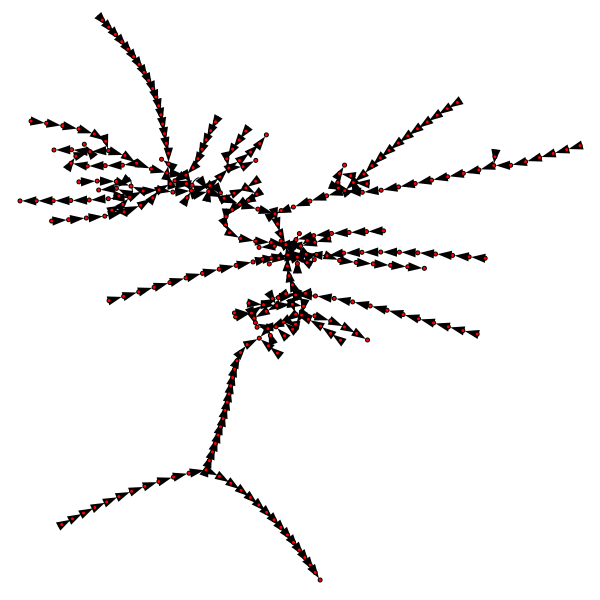

In [397]:
layout = g.layout_kamada_kawai(seed=None, maxiter=15000, kkconst=121)
ig.plot(g, vertex_size=4, layout=layout)
# https://igraph.org/python/doc/tutorial/tutorial.html

In [398]:
import svgwrite
from IPython.display import SVG, display
import numpy as np

In [399]:
# colors
colors= ["#d11141", '#00b159', '#00aedb', '#f37735', '#ffc425'] # metro

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

colors = [svgwrite.utils.rgb(r=c[0], g=c[1], b=c[2], mode='RGB')
          for c in tableau20]

In [400]:
len(nodes)*4

1184

In [401]:
size, margin = len(nodes) *6, 10
xy = np.array(layout.coords)
coords = {n:xy for n, xy in zip(nodes, (xy-xy.min())/xy.ptp()*(size-2*margin)+margin)}

In [402]:
dwg = svgwrite.Drawing('maps/'+blob.name+'.svg',
                       profile='full',
                       size=(size, size),
                       style="background-color:white; alpha:0%;")

In [403]:
for k, chain in enumerate(blob.chains.values()):
    color = colors[k%len(colors)]
    d = "M "
    d += " L ".join(['%f %f'%tuple(coords[m[0]]) for m in chain])
    dwg.add(svgwrite.path.Path(d, fill='none', stroke=color,
                              stroke_width='5'))
    dwg.add(svgwrite.Drawing().circle(center=coords[chain[0][0]], r=7,
                                      fill=color))
    for n in chain[1:]:
        dwg.add(svgwrite.Drawing().circle(center=coords[n[0]],
                                          r=4,
                                          fill=color))
        dwg.add(svgwrite.Drawing().circle(center=coords[n[0]],
                                          r=2,
                                          fill='white'))
dwg.save()

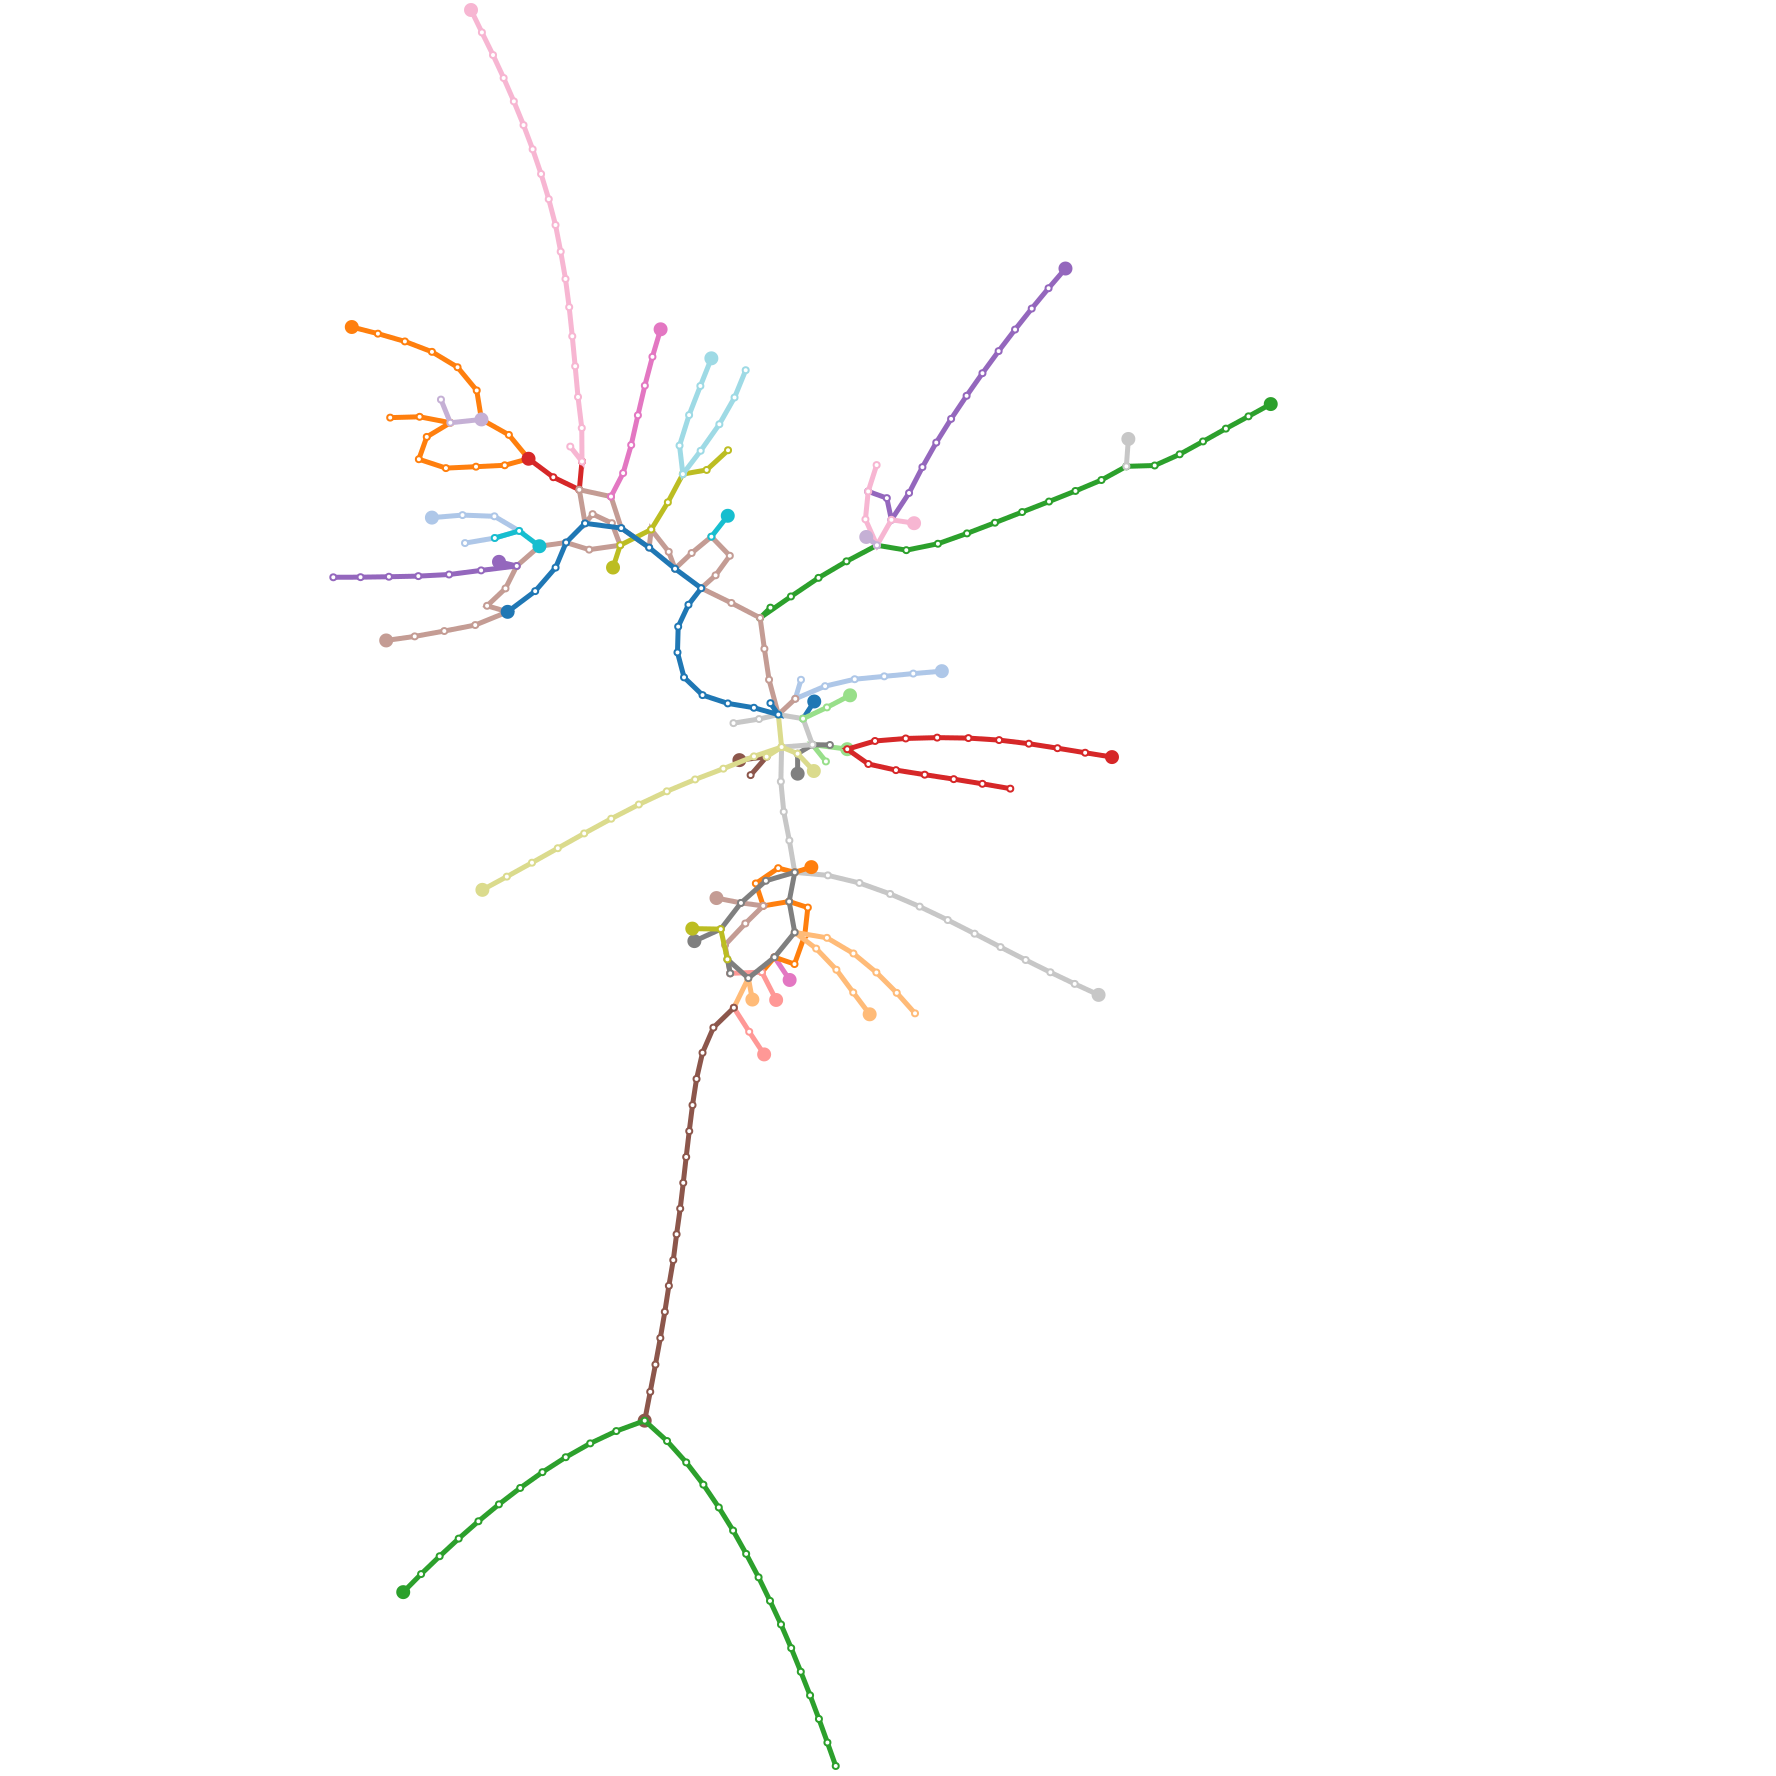

In [404]:
display(dwg)

In [ ]:
# Export graph
g.write('data/subway.gml')

## Simple Graph

In [ ]:
# load
blob = pickle.load( open(blobname, "rb") )

In [ ]:
thesis = list(blob.thesis.values())
print(len(thesis))

edges = set()
nodes = set()
for th in thesis:
    nodes.add(th['author'])
    for adviser in th['directors']:
        edges.add((th['author'], adviser))
        nodes.add(adviser)
        #break # only one adviser...
        
edges = list(edges)
nodes = list(nodes)
print('edges:', len(edges))
print('nodes:', len(nodes))

In [ ]:
edges_by_idx = [(nodes.index(u), nodes.index(v))
                for u, v in edges]

# graph
g = ig.Graph(directed=False)
g.add_vertices(nodes)
g.add_edges(edges_by_idx)

print('vertex:', len(g.vs))

https://schneide.blog/tag/fruchterman-reingold/

In [ ]:
layout = g.layout_reingold_tilford_circular()
#layout = g.layout_kamada_kawai()
ig.plot(g, vertex_size=4, layout=layout)
# https://igraph.org/python/doc/tutorial/tutorial.html